In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

In [2]:
%%time
#Importing datasets source for the dataset provided in the report as well as readme file.

trips = pd.read_csv('trips2019.csv')
segments = pd.read_csv('terminals.csv')
weather_d = pd.read_csv('weather19_daily.csv')


Wall time: 36.7 s


In [3]:
file_path = ['hourly_weather/jan.csv','hourly_weather/feb.csv','hourly_weather/mar.csv',
             'hourly_weather/apr.csv','hourly_weather/may.csv','hourly_weather/jun.csv','hourly_weather/july.csv',]





weather_h = pd.DataFrame()

for f in file_path:

    df = pd.read_csv(f)
    weather_h = pd.concat([weather_h, df])
    
weather_h.reset_index(inplace = True, drop = True)

## Data Dictionary

### Trips dataset (Jan - July 2019)

- LinkId(text): Unique identifier of the journey time segment. Format LXX_AA-BB, route XXidentifier, AAsource BBidentifier , destination identifier. This idenfiant makes it possible to make the link with the road segment data collection for the collection of journey times

- SrcDetectorId (text): Unique identifier of the segment's original sensor

- DestDetectorId (text): Unique identifier of the segment destination sensor

- PathDistance_m (int): Length of the segment, in meters.

- TripStart_dt (datetime): Date and time of capture at the point of origin of the segment in format AAAA-MM-JJ HH:MM:SS

- TripEnd_dt (datetime): Date and time of capture at segment destination point in format AAAA-MM-JJ HH:MM:SS

- Speed_kmh (float): Average speed calculated on the segment, in kilometers per hour. /n

- TravelTime_s (int): Travel time calculated on the segment, in seconds.

### Terminals (Checkpoints) dataset

- IdLink (int): Unique identifier of the journey time segment.

- channel_name (text): Channel name

- active(bool): Activity of the segment at the time of data export. 0: inactive,1

- LinkID(text): Textual identifier of the journey time segment. Format LXX_AA-BB, XX: identifier of the artery AA: identification of the source BB: identifying the destination.

- SrcDetectorId (int): Identifier of the segment origin sensor (starting point)

- SrcLatitude (float): Latitude of the segment's original sensor according to the WGS84 standard.

- SrcLongitude (float): Longitude of the original capture of the segment according to the WGS84 standard.

- DestDetectorId (int): Identifier of the segment destination sensor (end point).

- DestLatitude (float): Latitude of the destination sensor according to the WGS84 standard.

- DestLongitude (float): Longitude of the destination sensor according to the WGS84 standard.

- LinkName (text): Full name of the segment.

- RouteDirectionName(text): Direction segment of travel time along the axis of the road segment. N: north E,: east S,: south O,: west.

- SrcChannelId (int): Unique identifier of the original channel

- DestChannelId (int): Unique identifier of the destination channel.

- LineDistance_m (int): Length of the segment in meters.

- last_poll_time(datetime): Date and time of the last sensor data collection in format AAAA-MM-JJ HH:MM:SS:mmm



### Weather dataset:

The data dictionary can be found here: https://climate.weather.gc.ca/glossary_e.html#meanTemp

## Know your Data

In [4]:
#peeking into trips dataframe
trips.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,TripStart_dt,TripEnd_dt,Speed_kmh,TravelTime_s
0,LSD_89-87,89,87,308,2019-01-01 04:42:17,2019-01-01 04:43:42,13.044706,85
1,LRL_37-1B,37,1B,435,2019-01-01 04:41:31,2019-01-01 04:43:43,11.863636,132
2,LSD_50-30,50,30,476,2019-01-01 04:42:33,2019-01-01 04:43:44,24.135211,71
3,LSH_93-81,93,81,208,2019-01-01 04:36:15,2019-01-01 04:43:45,1.664000,450
4,LND_1B-98,1B,98,369,2019-01-01 04:43:21,2019-01-01 04:43:46,53.136000,25


In [5]:
#Checking trips df info for data types and any missing values
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800951 entries, 0 to 14800950
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LinkId          object 
 1   SrcDetectorId   object 
 2   DestDetectorId  object 
 3   PathDistance_m  int64  
 4   TripStart_dt    object 
 5   TripEnd_dt      object 
 6   Speed_kmh       float64
 7   TravelTime_s    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 903.4+ MB


In [6]:
#Analysing trips dataset
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
PathDistance_m,14800951.0,801.460889,641.623817,101.000,305.000000,577.000000,1164.00,4213.0
Speed_kmh,14800951.0,25.769026,16.633735,0.202,13.082927,23.238323,35.55,75.0
TravelTime_s,14800951.0,197.557973,281.201459,7.000,51.000000,105.000000,214.00,2700.0


In [7]:
#peeking into segments dataset
segments.head()

,IdLink,channel_name,active,LinkID,SrcDetectorId,SrcLatitude,SrcLongitude,DestDetectorId,DestLatitude,DestLongitude,LinkName,RouteDirectionName,SrcChannelId,DestChannelId,LineDistance_m,last_poll_time
0,1,Saint-Michel-Industriel,1,LCh_10-16,10,"45,5760283333333","-73,6364616666667",16,"45,564785","-73,6449433333333",Charland:Saint-Michel a Papineau,O,11,17,1410,2019-07-02 18:44:59
1,2,Papineau-charland,1,LCh_16-10,16,"45,564785","-73,6449433333333",10,"45,5760283333333","-73,6364616666667",Charland:Papineau a Saint-Michel,N,17,11,1414,2019-07-02 18:44:58
2,3,Papineau-Henri-Bourassa,1,LHB_15-20,15,"45,5702683333333","-73,6588066666667",20,"45,555365","-73,6683933333333",Henri-Bourassa:Papineau a Lajeunesse,O,16,21,1818,2019-07-02 18:44:57
3,4,Henri-Bourassa-Lajeunesse,1,LHB_20-15,20,"45,555365","-73,6683933333333",15,"45,5702683333333","-73,6588066666667",Henri-Bourassa:Lajeunesse a Papineau,N,21,16,1818,2019-02-15 13:56:37
4,5,Henri-Bourassa-Lajeunesse,1,LHB_20-21,20,"45,555365","-73,6683933333333",21,"45,5349866666667","-73,6807116666667",Henri_Bourassa:Lajeunesse a Bourassa-Acadie,O,21,22,2460,2019-02-15 13:56:37


In [8]:
#Checking segments dataframe info for data types and any missing values
segments.info()

#Seems like there are some values missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   IdLink              330 non-null    int64 
 1   channel_name        330 non-null    object
 2   active              330 non-null    int64 
 3   LinkID              330 non-null    object
 4   SrcDetectorId       330 non-null    object
 5   SrcLatitude         330 non-null    object
 6   SrcLongitude        330 non-null    object
 7   DestDetectorId      330 non-null    object
 8   DestLatitude        330 non-null    object
 9   DestLongitude       330 non-null    object
 10  LinkName            330 non-null    object
 11  RouteDirectionName  330 non-null    object
 12  SrcChannelId        330 non-null    int64 
 13  DestChannelId       330 non-null    int64 
 14  LineDistance_m      330 non-null    int64 
 15  last_poll_time      311 non-null    object
dtypes: int64(5), object(11)
me

In [9]:
weather_d.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01,2019,1,1,NaN,2.4,...,0.2,NaN,17.0,NaN,0.0,T,29.0,NaN,52.0,NaN
1,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-02,2019,1,2,NaN,-9.4,...,0.4,NaN,0.4,NaN,0.0,T,NaN,M,NaN,M
2,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-03,2019,1,3,NaN,-1.5,...,4.6,NaN,4.6,NaN,4.0,NaN,2.0,NaN,32.0,NaN
3,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-04,2019,1,4,NaN,2.5,...,3.0,NaN,3.0,NaN,6.0,NaN,23.0,NaN,48.0,NaN
4,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-05,2019,1,5,NaN,2.3,...,0.0,NaN,0.0,T,1.0,E,NaN,M,NaN,M


In [10]:
#Checking weather dataframe info for data types and any missing values
weather_d.info()

#Seems like quite a lot of missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude (x)              365 non-null    float64
 1   Latitude (y)               365 non-null    float64
 2   Station Name               365 non-null    object 
 3   Climate ID                 365 non-null    int64  
 4   Date/Time                  365 non-null    object 
 5   Year                       365 non-null    int64  
 6   Month                      365 non-null    int64  
 7   Day                        365 non-null    int64  
 8   Data Quality               0 non-null      float64
 9   Max Temp (°C)              361 non-null    float64
 10  Max Temp Flag              4 non-null      object 
 11  Min Temp (°C)              361 non-null    float64
 12  Min Temp Flag              4 non-null      object 
 13  Mean Temp (°C)             361 non-null    float64

In [11]:
weather_d.describe().T

,count,mean,std,min,25%,50%,75%,max
Longitude (x),365.0,-7.374000e+01,5.265234e-13,-73.74,-73.74,-73.74,-73.74,-73.74
Latitude (y),365.0,4.547000e+01,2.703769e-13,45.47,45.47,45.47,45.47,45.47
Climate ID,365.0,7.025251e+06,0.000000e+00,7025251.00,7025251.00,7025251.00,7025251.00,7025251.00
Year,365.0,2.019000e+03,0.000000e+00,2019.00,2019.00,2019.00,2019.00,2019.00
Month,365.0,6.526027e+00,3.452584e+00,1.00,4.00,7.00,10.00,12.00
Day,365.0,1.572055e+01,8.808321e+00,1.00,8.00,16.00,23.00,31.00
Data Quality,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Temp (°C),361.0,1.100000e+01,1.260811e+01,-16.40,0.90,11.10,21.20,33.00
Min Temp (°C),361.0,1.839058e+00,1.158724e+01,-23.10,-7.40,3.10,11.50,23.30
Mean Temp (°C),361.0,6.426870e+00,1.201587e+01,-19.10,-3.20,7.10,16.60,28.20


In [12]:
weather_h.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01 00:00,2019,1,1,00:00,1.9,...,NaN,8.1,NaN,99.89,NaN,NaN,NaN,NaN,NaN,"Rain,Fog"
1,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01 01:00,2019,1,1,01:00,1.7,...,NaN,4.8,NaN,99.61,NaN,NaN,NaN,NaN,NaN,"Rain,Fog"
2,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01 02:00,2019,1,1,02:00,1.9,...,NaN,4.8,NaN,99.38,NaN,NaN,NaN,NaN,NaN,"Rain,Fog"
3,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01 03:00,2019,1,1,03:00,2.3,...,NaN,9.7,NaN,99.08,NaN,NaN,NaN,NaN,NaN,"Rain,Fog"
4,-73.74,45.47,MONTREAL INTL A,7025251,2019-01-01 04:00,2019,1,1,04:00,2.0,...,NaN,8.1,NaN,98.88,NaN,NaN,NaN,NaN,NaN,"Rain,Fog"


In [13]:
weather_h.info()
# A lot of null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        5088 non-null   float64
 1   Latitude (y)         5088 non-null   float64
 2   Station Name         5088 non-null   object 
 3   Climate ID           5088 non-null   int64  
 4   Date/Time            5088 non-null   object 
 5   Year                 5088 non-null   int64  
 6   Month                5088 non-null   int64  
 7   Day                  5088 non-null   int64  
 8   Time                 5088 non-null   object 
 9   Temp (°C)            5087 non-null   float64
 10  Temp Flag            0 non-null      float64
 11  Dew Point Temp (°C)  5087 non-null   float64
 12  Dew Point Temp Flag  0 non-null      float64
 13  Rel Hum (%)          5087 non-null   float64
 14  Rel Hum Flag         0 non-null      float64
 15  Wind Dir (10s deg)   5081 non-null   f

## Cleaning and EDA

Firstly, in our `segments` df we have a column indicating if a column is active or not. We will use it and remove the inactive segments

In [14]:
#Checking for inactive segments
pd.DataFrame(segments['active'].value_counts())

,active
1,303
0,27


In [15]:
#Since there are 27 inactive segments we will remove them from our segment data analysis
segments.drop(segments[segments.active == 0].index, inplace=True)

#Check again

segments.reset_index(inplace=True)

print(pd.DataFrame(segments['active'].value_counts()))
#Worked! 

   active
1     303


In [16]:
#Checking for any null values in segments and trips data set
print('Segments data')
print(segments.isna().sum(),'\n')

print('Trips data')
print(trips.isna().sum())
#No Null value found at this stage in trips and segments data set.

Segments data
index                 0
IdLink                0
channel_name          0
active                0
LinkID                0
SrcDetectorId         0
SrcLatitude           0
SrcLongitude          0
DestDetectorId        0
DestLatitude          0
DestLongitude         0
LinkName              0
RouteDirectionName    0
SrcChannelId          0
DestChannelId         0
LineDistance_m        0
last_poll_time        0
dtype: int64 

Trips data
LinkId            0
SrcDetectorId     0
DestDetectorId    0
PathDistance_m    0
TripStart_dt      0
TripEnd_dt        0
Speed_kmh         0
TravelTime_s      0
dtype: int64


In [17]:
#lets look at weather data
print('Daily Weather data\n')
print(weather_d.isna().sum())

print('\n Hourly Weather data\n')
print(weather_h.isna().sum())


#The weather data will need some work!

Daily Weather data

Longitude (x)                  0
Latitude (y)                   0
Station Name                   0
Climate ID                     0
Date/Time                      0
Year                           0
Month                          0
Day                            0
Data Quality                 365
Max Temp (°C)                  4
Max Temp Flag                361
Min Temp (°C)                  4
Min Temp Flag                361
Mean Temp (°C)                 4
Mean Temp Flag               361
Heat Deg Days (°C)             4
Heat Deg Days Flag           361
Cool Deg Days (°C)             4
Cool Deg Days Flag           361
Total Rain (mm)                1
Total Rain Flag              334
Total Snow (cm)                1
Total Snow Flag              332
Total Precip (mm)              0
Total Precip Flag            312
Snow on Grnd (cm)            219
Snow on Grnd Flag            321
Dir of Max Gust (10s deg)     78
Dir of Max Gust Flag         304
Spd of Max Gust (km/h) 

Our `trips` and `segments` data set looks free of any null values but the `weather` datasets seems to hold quiet few of those so we will address those. But lets check for duplicates first:

In [18]:
#Checking for duplicates in trips
trips.duplicated().value_counts()

False    14781514
True        19437
dtype: int64

In [19]:
#Seems like there are over 19000 trips that were duplicated in our data set. So lets drop them
trips.drop_duplicates(keep = 'first', inplace = True)

#Check if the duplicates are removed
trips.shape

(14781514, 8)

In [20]:
#Checking for duplicates in Segments
segments.duplicated().value_counts()

False    303
dtype: int64

In [21]:
weather_d.duplicated().value_counts()

False    365
dtype: int64

In [22]:
weather_h.duplicated().value_counts()

False    5088
dtype: int64

Only `trips` dataset had some duplicates and we have successfully removed the duplicates. 

### Cleaning `weather` datasets

In [23]:
#Lets check the shape of the data. 
weather_d.shape

#There are 31 columns and we will need to lookinto each of these to see 
#if there is any use of a given column

(365, 31)

From our examination above we noticed that some columns in both data sets were missing a substantial amount of values so we'll simply get rid of these columns along with any column that will not hold any significant contributing factor towards our data. 

Lets start with dropping unnecessary columns first. 

## Daily weather first

In [24]:
#Lets look at the null value count again for daily weather first

print(weather_d.isna().sum())

Longitude (x)                  0
Latitude (y)                   0
Station Name                   0
Climate ID                     0
Date/Time                      0
Year                           0
Month                          0
Day                            0
Data Quality                 365
Max Temp (°C)                  4
Max Temp Flag                361
Min Temp (°C)                  4
Min Temp Flag                361
Mean Temp (°C)                 4
Mean Temp Flag               361
Heat Deg Days (°C)             4
Heat Deg Days Flag           361
Cool Deg Days (°C)             4
Cool Deg Days Flag           361
Total Rain (mm)                1
Total Rain Flag              334
Total Snow (cm)                1
Total Snow Flag              332
Total Precip (mm)              0
Total Precip Flag            312
Snow on Grnd (cm)            219
Snow on Grnd Flag            321
Dir of Max Gust (10s deg)     78
Dir of Max Gust Flag         304
Spd of Max Gust (km/h)        78
Spd of Max

Some of the columns here are missing more than 70% of the values. We will render such columns as useless, along with any other columns that hold stationary values and do not provide any significant power. 

In [25]:
#dropping columns
weather_d.drop(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
              'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag',
              'Total Rain Flag', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd Flag',
              'Dir of Max Gust Flag', 'Spd of Max Gust Flag', 'Cool Deg Days Flag',
              'Max Temp (°C)', 'Min Temp (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)',
              'Heat Deg Days (°C)', 'Total Precip (mm)', 'Dir of Max Gust (10s deg)', 'Mean Temp (°C)',
               'Spd of Max Gust (km/h)'], axis=1, inplace = True) 

##### Reasons to drop each column:
- Longitude (x): Since we assumed that the weather is same througout the city We will ignore the location of weather source
- Latitude (y): Since we assumed that the weather is same througout the city We will ignore the location of weather source
- Station Name: Since we assumed that the weather is same througout the city We will ignore the name of weather source
- Climate ID:Since we assumed that the weather is same througout the city We will ignore the ID of weather source
- Year: We already know we are only analysing data from year 2019 so year is irrelevant to the predictive model
- Data Quality: All null values
- Max Temp (°C): For simplicity we will use mean temp and get rid of Max and Min Temp column
- Min Temp (°C): For simplicity we will use mean temp and get rid of Max and Min Temp column
- Cool Deg Days (°C):  Not useful for our model. It measures temp below 18°C to determine heating req. of buildings
- Heat Deg Days (°C): Not useful for our model. It measures temp above 18°C to determine heating req. of buildings 
- Total Precip (mm): It is very closely corelated with `Total Rain (mm)` and `Total Snow (cm)` data. 
- Max Temp Flag: More than 90% null values
- Min Temp Flag: More than 90% null values
- Mean Temp Flag: More than 90% null values
- Total Rain Flag: More than 90% null values
- Total Snow Flag: More than 90% null values
- Total Precip Flag: More than 90% null values
- Snow on Grnd Flag: More than 90% null values
- Dir of Max Gust Flag: More than 90% null values
- Spd of Max Gust Flag: More than 90% null values
- Cool Deg Days Flag: More than 90% null values
- Heat Deg Days Flag: More than 90% null values
- Dir of Max Gust (10s deg): More accurate version is available in hourly data
- Mean Temp (°C): More accurate version is available in hourly data
- Spd of Max Gust (km/h): More accurate version is available in hourly data


In [26]:
#Checking null once again
(weather_d.isna().sum())

Date/Time              0
Month                  0
Day                    0
Total Rain (mm)        1
Total Snow (cm)        1
Snow on Grnd (cm)    219
dtype: int64

##### Lets address null values now! 

- `Snow on Grnd (cm)` has 219 null values primarily due to summer months where snow on ground is not observed. Therefore, we will replace this with 0.

- `Total Rain (mm)` and `Total Snow (cm)` each has 1 missing value we will just fill it with 0 to record them as no rain or snow recorded that day.

- `Dir of Max Gust (10s deg)` has 78 missing values and the wind direction is more relevant to its neighbouring days than a mean, median or any other measure of central tendency

In [27]:
#Filling null values using .fillna() method based on the justification above
weather_d['Snow on Grnd (cm)'].fillna(method = 'bfill', inplace = True)
#bfill because if there is snow on the ground previous day its likely to be there next day

weather_d['Total Rain (mm)'].fillna(0, inplace = True)
#imputing 0 because no data available means we cannot make a random guess on this. hourly data may add more info

weather_d['Total Snow (cm)'].fillna(0, inplace = True)
#Same reason as for total rain. hourly weather data may add info here as well

#Check for any potential null values now
(weather_d.isna().sum())

Date/Time            0
Month                0
Day                  0
Total Rain (mm)      0
Total Snow (cm)      0
Snow on Grnd (cm)    0
dtype: int64

In [28]:
weather_d.head()

,Date/Time,Month,Day,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,2019-01-01,1,1,16.8,0.2,0.0
1,2019-01-02,1,2,0.0,0.4,0.0
2,2019-01-03,1,3,0.0,4.6,4.0
3,2019-01-04,1,4,0.0,3.0,6.0
4,2019-01-05,1,5,0.0,0.0,1.0


### Lets look at hourly weather data now

In [29]:
weather_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        5088 non-null   float64
 1   Latitude (y)         5088 non-null   float64
 2   Station Name         5088 non-null   object 
 3   Climate ID           5088 non-null   int64  
 4   Date/Time            5088 non-null   object 
 5   Year                 5088 non-null   int64  
 6   Month                5088 non-null   int64  
 7   Day                  5088 non-null   int64  
 8   Time                 5088 non-null   object 
 9   Temp (°C)            5087 non-null   float64
 10  Temp Flag            0 non-null      float64
 11  Dew Point Temp (°C)  5087 non-null   float64
 12  Dew Point Temp Flag  0 non-null      float64
 13  Rel Hum (%)          5087 non-null   float64
 14  Rel Hum Flag         0 non-null      float64
 15  Wind Dir (10s deg)   5081 non-null   f

In [30]:
#dropping columns with a lot of null values and location info
weather_h.drop(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
              'Dew Point Temp Flag', 'Temp Flag', 'Rel Hum Flag', 'Wind Dir Flag',
              'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag',
              'Wind Chill Flag', 'Hmdx', 'Wind Chill'], axis=1, inplace = True) 

In [31]:
weather_h.isna().sum()

Date/Time                 0
Month                     0
Day                       0
Time                      0
Temp (°C)                 1
Dew Point Temp (°C)       1
Rel Hum (%)               1
Wind Dir (10s deg)        7
Wind Spd (km/h)           1
Visibility (km)           2
Stn Press (kPa)           1
Weather                2673
dtype: int64

In [32]:
#Filling null values using .fillna() method based on the justification below each if necessary
weather_h['Temp (°C)'].fillna(method = 'bfill', inplace = True)
weather_h['Dew Point Temp (°C)'].fillna(method = 'bfill', inplace = True)
weather_h['Rel Hum (%)'].fillna(method = 'bfill', inplace = True)
weather_h['Wind Spd (km/h)'].fillna(method = 'bfill', inplace = True)
weather_h['Stn Press (kPa)'].fillna(method = 'bfill', inplace = True)
weather_h['Wind Dir (10s deg)'].fillna(method = 'bfill', inplace = True)
weather_h['Visibility (km)'].fillna(method = 'bfill', inplace = True)

#The data is hourly, we are misisng a fraction of data in each of above columns so we would take the preceeding hourly data

In [33]:
#Lets inspect weather column now and see any trend in the missing values
null_values = weather_h[weather_h.isnull().any(axis=1)]

In [34]:
#Checking the spread of missing values
null_values['Time'].value_counts()

#Seems like all hours had almost same amount of missing values

14:00    174
02:00    170
15:00    170
00:00    169
20:00    169
23:00    169
03:00    168
05:00    168
18:00    168
12:00    166
21:00    166
17:00    166
06:00    165
11:00    165
08:00    160
09:00    159
22:00      1
Name: Time, dtype: int64

In [35]:
#Checking the spread of missing values
null_values.groupby('Day')['Time'].value_counts().unstack()

Time,00:00,02:00,03:00,05:00,06:00,08:00,09:00,11:00,12:00,14:00,15:00,17:00,18:00,20:00,21:00,22:00,23:00
Day,,,,,,,,,,,,,,,,,
1,4.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,1.0,6.0
2,6.0,7.0,7.0,6.0,6.0,6.0,6.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,NaN,6.0
3,5.0,5.0,5.0,6.0,5.0,6.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,NaN,3.0
4,4.0,3.0,4.0,5.0,5.0,5.0,6.0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,6.0
5,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,6.0,7.0,6.0,5.0,5.0,5.0,6.0,NaN,6.0
6,6.0,6.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,NaN,6.0
7,6.0,5.0,6.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,6.0,7.0,7.0,7.0,6.0,NaN,4.0
8,4.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,NaN,5.0
9,6.0,6.0,6.0,6.0,7.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,NaN,5.0


Since the missing weather is almost evenly spread we can use bfill for this as well assuming we will have same or similar weather in the previus hour.

In [36]:
#Filling values for Weather column based on the following available data
weather_h['Weather'].fillna(method = 'ffill', inplace = True)

In [37]:
weather_h.isna().sum()

Date/Time              0
Month                  0
Day                    0
Time                   0
Temp (°C)              0
Dew Point Temp (°C)    0
Rel Hum (%)            0
Wind Dir (10s deg)     0
Wind Spd (km/h)        0
Visibility (km)        0
Stn Press (kPa)        0
Weather                0
dtype: int64

In [38]:
#Checking the entry types in weather column
weather_h['Weather'].value_counts()

Mostly Cloudy                                     1151
Clear                                              892
Cloudy                                             889
Mainly Clear                                       872
Snow                                               331
Rain                                               302
Snow,Blowing Snow                                  113
Blowing Snow                                        93
Rain,Fog                                            80
Rain Showers                                        73
Drizzle                                             37
Fog                                                 35
Snow Showers                                        31
Drizzle,Fog                                         28
Freezing Drizzle,Fog                                28
Snow,Fog                                            14
Freezing Drizzle,Snow,Fog                           13
Freezing Rain,Fog                                   13
Rain,Snow 

We have a range of entries in the weather column for hourly weather so we are going to do some ordinal encoding on it to make it easier for our Machine Learning model to learn from this information. We will encode weather between 1-10 such as 1 being Clear or Mainly clear and 10 being the worst weather conditions from driving and road conditions prespective. Grouping will be done based on similar weather type.

In [39]:
#Ordinal encoding on weather column in hourly weather data

weather_h['Weather'] = weather_h['Weather'].replace(['Clear', 'Mainly Clear'], '1')

weather_h['Weather'] = weather_h['Weather'].replace(['Cloudy', 'Mostly Cloudy'], '2')

weather_h['Weather'] = weather_h['Weather'].replace(['Drizzle', 'Rain'], '3')

weather_h['Weather'] = weather_h['Weather'].replace(['Moderate Rain', 'Rain Showers', 'Rain,Rain Showers',
                                                     'Drizzle,Fog'], '4')

weather_h['Weather'] = weather_h['Weather'].replace(['Moderate Rain,Fog', 'Rain,Fog', 'Fog', 'Rain Showers,Fog'], '5')

weather_h['Weather'] = weather_h['Weather'].replace(['Snow', 'Snow Showers', 'Snow,Fog', 'Rain,Snow'], '6')

weather_h['Weather'] = weather_h['Weather'].replace(['Snow,Blowing Snow', 'Snow Showers,Blowing Snow', 'Moderate Snow',
                                                     'Freezing Drizzle,Snow,Blowing Snow', 'Snow Grains,Blowing Snow',
                                                    'Drizzle,Snow,Fog','Blowing Snow','Moderate Snow,Blowing Snow'], '7')

weather_h['Weather'] = weather_h['Weather'].replace(['Freezing Drizzle,Fog', 'Freezing Drizzle,Snow,Fog',
                                                     'Freezing Drizzle,Snow'], '8')

weather_h['Weather'] = weather_h['Weather'].replace(['Freezing Rain,Fog', 'Freezing Rain', 'Drizzle,Snow Grains,Fog',
                                                     'Freezing Drizzle,Snow,Ice Pellets,Blowing Snow', 'Snow Grains',
                                                'Snow,Ice Pellets', 'Freezing Drizzle,Ice Pellets,Fog',
                                                'Freezing Drizzle,Snow,Ice Pellets', 'Freezing Rain,Snow,Ice Pellets',
                                                  'Freezing Drizzle,Ice Pellets,Fog,Blowing Snow'], '9')

weather_h['Weather'] = weather_h['Weather'].replace(['Thunderstorms,Rain', 'Thunderstorms', 'Thunderstorms,Rain Showers',
                                                    ], '10')

#Used 'https://climate.weather.gc.ca/glossary_e.html#weather' as a refernce point for this encoding

In [40]:
#Making sure ordinal coding worked
weather_h['Weather'].value_counts()

2     2040
1     1764
6      388
3      339
7      234
5      121
4      106
8       47
9       36
10      13
Name: Weather, dtype: int64

In [41]:
weather_h.head()

,Date/Time,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
0,2019-01-01 00:00,1,1,00:00,1.9,1.1,94.0,12.0,26.0,8.1,99.89,5
1,2019-01-01 01:00,1,1,01:00,1.7,0.6,92.0,14.0,28.0,4.8,99.61,5
2,2019-01-01 02:00,1,1,02:00,1.9,1.0,94.0,12.0,17.0,4.8,99.38,5
3,2019-01-01 03:00,1,1,03:00,2.3,1.4,94.0,10.0,22.0,9.7,99.08,5
4,2019-01-01 04:00,1,1,04:00,2.0,1.3,95.0,2.0,18.0,8.1,98.88,5


In [42]:
# I believe the dew point temp (beacuse rel hum column is there) and stn press are not relevant for our use of this data. 
# Therefore, I will drop these two columns 

In [43]:
weather_h.drop(['Dew Point Temp (°C)', 'Stn Press (kPa)' ], axis=1, inplace = True)

### Lets Address formatting issues in our segments dataset

Looking at our `segments` dataset earlier we noticed that longitude and latitudes were in french formatting therefore we will replace `,` with `.`.

In [44]:
#Converting Longitude and Latitude from french numeric standards to English statndard by replacing ',' with '.'

segments['SrcLatitude'] = segments['SrcLatitude'].str.replace(',','.')
segments['DestLatitude'] = segments['DestLatitude'].str.replace(',','.')
segments['SrcLongitude'] = segments['SrcLongitude'].str.replace(',','.')
segments['DestLongitude'] = segments['DestLongitude'].str.replace(',','.')
segments.head()

,index,IdLink,channel_name,active,LinkID,SrcDetectorId,SrcLatitude,SrcLongitude,DestDetectorId,DestLatitude,DestLongitude,LinkName,RouteDirectionName,SrcChannelId,DestChannelId,LineDistance_m,last_poll_time
0,0,1,Saint-Michel-Industriel,1,LCh_10-16,10,45.5760283333333,-73.6364616666667,16,45.564785,-73.6449433333333,Charland:Saint-Michel a Papineau,O,11,17,1410,2019-07-02 18:44:59
1,1,2,Papineau-charland,1,LCh_16-10,16,45.564785,-73.6449433333333,10,45.5760283333333,-73.6364616666667,Charland:Papineau a Saint-Michel,N,17,11,1414,2019-07-02 18:44:58
2,2,3,Papineau-Henri-Bourassa,1,LHB_15-20,15,45.5702683333333,-73.6588066666667,20,45.555365,-73.6683933333333,Henri-Bourassa:Papineau a Lajeunesse,O,16,21,1818,2019-07-02 18:44:57
3,3,4,Henri-Bourassa-Lajeunesse,1,LHB_20-15,20,45.555365,-73.6683933333333,15,45.5702683333333,-73.6588066666667,Henri-Bourassa:Lajeunesse a Papineau,N,21,16,1818,2019-02-15 13:56:37
4,4,5,Henri-Bourassa-Lajeunesse,1,LHB_20-21,20,45.555365,-73.6683933333333,21,45.5349866666667,-73.6807116666667,Henri_Bourassa:Lajeunesse a Bourassa-Acadie,O,21,22,2460,2019-02-15 13:56:37


In [45]:
segments['RouteDirectionName'].value_counts()

O    81
S    74
E    74
N    72
W     2
Name: RouteDirectionName, dtype: int64

We see that `W` only appeared twice and instead `O` representing `Ouest` which is french for west appeared 81 times. Therefore, we will address this and merge these two under `W` label. 

In [46]:
#Cleaning direction name section to match English
segments['RouteDirectionName'] = segments['RouteDirectionName'].replace ('O', 'W')

#testing to make sure it worked
pd.DataFrame(segments['RouteDirectionName'].value_counts())


,RouteDirectionName
W,83
S,74
E,74
N,72


We will now get rid of any unnecessary columns from the `segments` data set.

In [47]:
#Dropping selected columns
segments.drop (columns = ['active', 'IdLink', 'index', 'last_poll_time', 'DestChannelId', 'SrcChannelId' ], inplace = True)

##### Reasons to drop the columns selected above: 
- `active` column was though very helpful in our data cleaning process, it provides no predictive power.
- `IdLink` is an ID which provides no predictive power.
- `index` is a duplicated column
- `last_poll_time` is irrelevant for use of data as we will join the tables based on link_ids on `trips` dataset
- `DestChannelId` and `SrcChannelId` are repeating almost same information from `SrcDetectorId` and `DestDetectorId`. 

Looks like our weather dataset is fairly clean and ready for some Exploratory Data Analysis.

--- 

### LETS DO SOME EDA!

Lets start with analysing the segments and how many trips were recorded in our `trips` dataset.

In [48]:
#Checking how many segments were used for 2019 data with the trips data
pd.DataFrame(trips['LinkId'].value_counts())

,LinkId
LBF_1S-1Q,253738
LND_1M-1A,252698
LND_1D-1M,225917
LND_1F-1G,209099
LND_1G-1E,206027
...,...
LBe_86-85,1395
LHB_21-20,1393
LBF_1N-1O,1162
LND_52-53,7


There were 251 segments that were used in 2019. But 'LinkId' LND_52-53 and LND_53-54 recorded below 10 trips so
we should remove these trips and segments from both our dataset.

In [49]:
#Dropping trips on very low frequency segments 
trips.drop(trips[(trips.LinkId == 'LND_52-53') | (trips.LinkId == 'LND_53-54')].index, inplace = True)

In [50]:
#Checking if the drop was successful
pd.DataFrame(trips['LinkId'].value_counts())

,LinkId
LBF_1S-1Q,253738
LND_1M-1A,252698
LND_1D-1M,225917
LND_1F-1G,209099
LND_1G-1E,206027
...,...
LBF_1R-1O,2099
LPK_70-74,2060
LBe_86-85,1395
LHB_21-20,1393


## LETS ADDRESS TRIPS DATA

In [51]:
#Lets analyse our trips data in depth
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
PathDistance_m,14781504.0,801.330042,641.793204,101.000,305.000000,577.000000,1164.000000,4213.0
Speed_kmh,14781504.0,25.761933,16.634051,0.202,13.080916,23.226923,35.539535,75.0
TravelTime_s,14781504.0,197.596080,281.257681,7.000,51.000000,105.000000,214.000000,2700.0


Text(0.5, 0, 'Distance (m)')

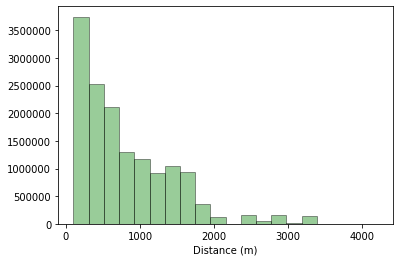

In [52]:
plt.hist((trips['PathDistance_m']), bins=20, alpha=0.4, color='g',edgecolor = 'k');
plt.xlabel('Distance (m)')

In [53]:
before_counts, bin_edges = np.histogram(trips['PathDistance_m'], bins=20)
trips_count_w_outliers = pd.DataFrame(before_counts).T

(0, 78.7399)

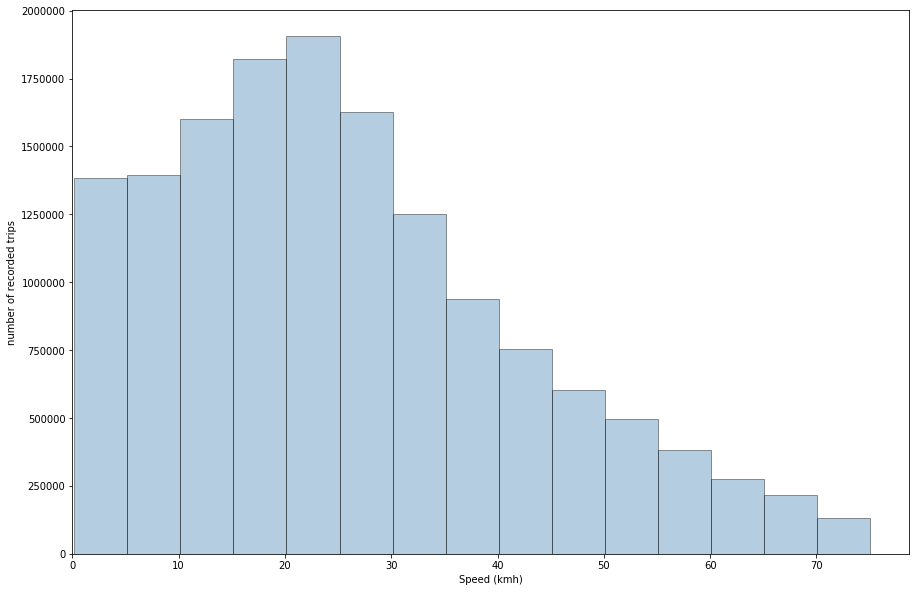

In [54]:
plt.figure(figsize = (15,10))
plt.hist(trips['Speed_kmh'], bins=15, alpha=0.4, color='steelblue',edgecolor = 'k');
plt.xlabel('Speed (kmh)')
plt.ylabel('number of recorded trips')
plt.xlim(0)

#Each bar is incrementing at 5km/h starting from 0 km/h

We note that the minimum speed and the max travel time seems to be outliers. Such slow speed may be a result of a pit stop between the two recording sensors on a trip or for some other extreme reason as even in rush hours speed should atleast be above 2km/h. Considering some of the roads may have 60 km/h as speed limit a max of 75 km/h is acceptable for recorded speed. 

We notice that the max `PathDistance_m` is 4213 meters and the `TravelTime_s` of as high as 2700 seconds does not make sense. Therefore, we will drop any records above 25 mins trip time. i.e. 1500 seconds.

In [55]:
#We will set the outlier criteria for the trips based on their average speed. Considering the data is not based on  any
#highway traffic trips that have the average speed of less than 3 km/h and more than 70km/h will be considered outliers

#Similarly our longest segment is 4213m which means at an average speed of as low as 20km/h it should not take more than
#12 mins or 720 seconds.  

print((trips['Speed_kmh'] < 10).value_counts())
print((trips['Speed_kmh'] > 65).value_counts())


False    12057052
True      2724452
Name: Speed_kmh, dtype: int64
False    14434597
True       346907
Name: Speed_kmh, dtype: int64


In [56]:
#Lets drop the rows where the speed was less than 2 km/h and the time taken was more than 720 seconds (12 mins)
# we assume these were the outliers and were caused by out of ordinary situations which we wont factor in our model

trips.drop(trips[trips.Speed_kmh < 10].index, inplace=True)
trips.drop(trips[trips.Speed_kmh > 65].index, inplace=True)

(0, 1589.3500000000001)

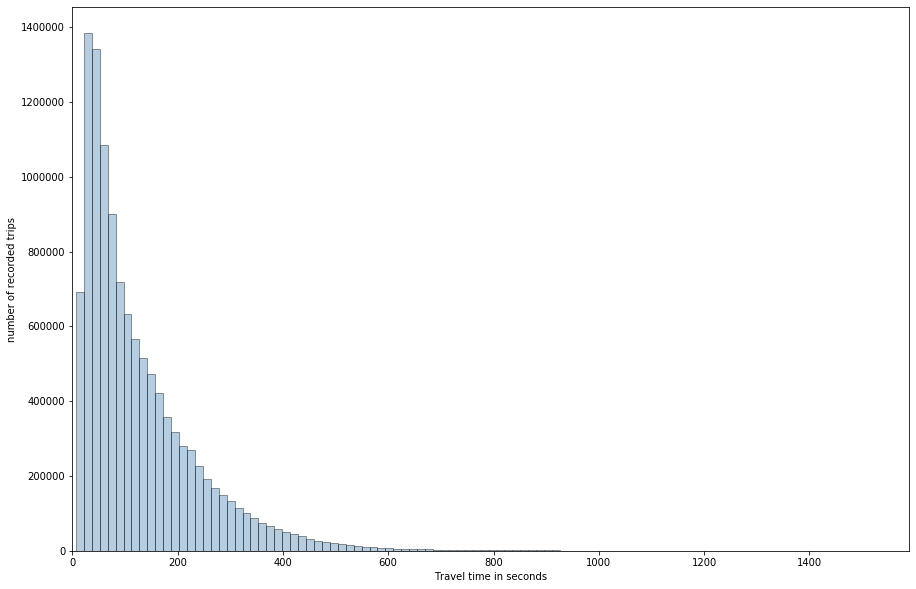

In [57]:
plt.figure(figsize = (15,10))
plt.hist(trips['TravelTime_s'], bins=100, alpha=0.4, color='steelblue',edgecolor = 'k')
plt.xlabel('Travel time in seconds')
plt.ylabel('number of recorded trips')
plt.xlim(0)

In [58]:
#Lets look at travel_time outliers
print((trips['TravelTime_s'] > 960).value_counts())

False    11704293
True         5852
Name: TravelTime_s, dtype: int64


In [59]:
#dropping columns with extraordinarily long time
trips.drop(trips[trips.TravelTime_s > 960].index, inplace=True)

(0, 1007.6499999999999)

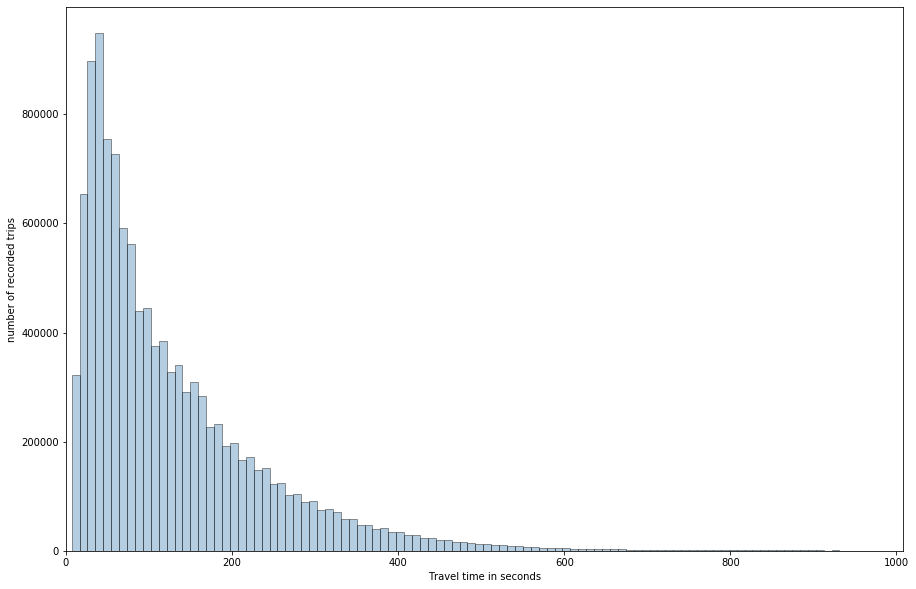

In [60]:
plt.figure(figsize = (15,10))
plt.hist(trips['TravelTime_s'], bins=100, alpha=0.4, color='steelblue',edgecolor = 'k')
plt.xlabel('Travel time in seconds')
plt.ylabel('number of recorded trips')
plt.xlim(0)

In [61]:
after_counts, bin_edges = np.histogram(trips['PathDistance_m'], bins=20)
trips_count_without_outliers = pd.DataFrame(after_counts).T

(0, 3937539.0502554863)

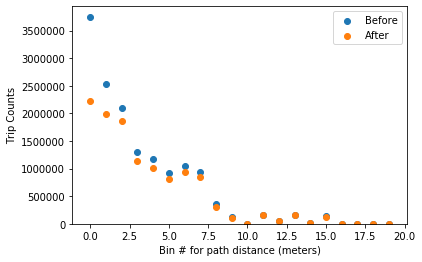

In [62]:
plt.scatter(range(20), trips_count_w_outliers, label = 'Before')
plt.scatter(range(20), trips_count_without_outliers, label = 'After')
plt.legend()
plt.xlabel('Bin # for path distance (meters)')
plt.ylabel('Trip Counts')
plt.ylim(0)



Comparing which segments had the most of their trips lie in speed outliers and seems like shorter segments tend to record smaller speeds or extremely high speeds. This could be due to sensors recording data from pedestrians or cyclists who tend to be using these routes as well.

---
We are now going to create seperate columns for hour, day, month and weekday based on `Trip_Start_dt` from `trips` dataset to use the date and time as a feature for our model.

In [63]:
#rename column.

trips['trip_start'] = pd.to_datetime(trips['TripStart_dt'])
trips['trip_end'] = pd.to_datetime(trips['TripEnd_dt'])

#drop original column
trips.drop (columns = ['TripStart_dt', 'TripEnd_dt'  ], inplace = True)


In [64]:
#Separating day, month, weekday and hour for modelling prep
trips['month'] = pd.DatetimeIndex(trips['trip_start']).month

# Following will output Numeric weekday where 0 is Monday 1 is Tuesday and so on... 
trips['weekday'] = trips['trip_start'].dt.weekday

# Will generate hours based on 24 hr format
trips['hour'] = trips['trip_start'].dt.hour

#Will generate day of the month. This will not hold any predicitive power but will be useful in joining tables later on
trips['day_of_month'] = pd.DatetimeIndex(trips['trip_start']).day



In [65]:
#getting hour from hourly weather data to make a new column to join
weather_h['hour'] = pd.DatetimeIndex(weather_h['Date/Time']).hour

In [66]:
#peeking to see how data looks
trips.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,trip_start,trip_end,month,weekday,hour,day_of_month
0,LSD_89-87,89,87,308,13.044706,85,2019-01-01 04:42:17,2019-01-01 04:43:42,1,1,4,1
1,LRL_37-1B,37,1B,435,11.863636,132,2019-01-01 04:41:31,2019-01-01 04:43:43,1,1,4,1
2,LSD_50-30,50,30,476,24.135211,71,2019-01-01 04:42:33,2019-01-01 04:43:44,1,1,4,1
4,LND_1B-98,1B,98,369,53.136000,25,2019-01-01 04:43:21,2019-01-01 04:43:46,1,1,4,1
5,LSD_89-87,89,87,308,20.160000,55,2019-01-01 04:42:51,2019-01-01 04:43:46,1,1,4,1


In [67]:
month_count = trips['month'].value_counts()
weekday_count = trips['weekday'].value_counts()
hourly_count = trips['hour'].value_counts()

In [68]:
#Quick check on the new columns to ensure our data is evenly spread. 

print('month \n',month_count, '\n')
print('weekday \n',weekday_count, '\n')
print('Hour \n', hourly_count, '\n')

month 
 5    2197044
6    2191427
4    1975279
3    1773212
2    1631007
1    1512686
7     423638
Name: month, dtype: int64 

weekday 
 4    1934538
2    1880192
1    1830916
3    1823978
0    1615557
5    1440292
6    1178820
Name: weekday, dtype: int64 

Hour 
 17    738177
16    731244
15    728301
8     716624
14    696933
9     676902
7     675948
13    663261
11    654209
12    649826
10    646032
18    613344
6     489508
19    471269
20    395693
21    371808
22    347211
23    287573
5     277662
0     223649
1     187690
2     164331
3     153387
4     143711
Name: hour, dtype: int64 



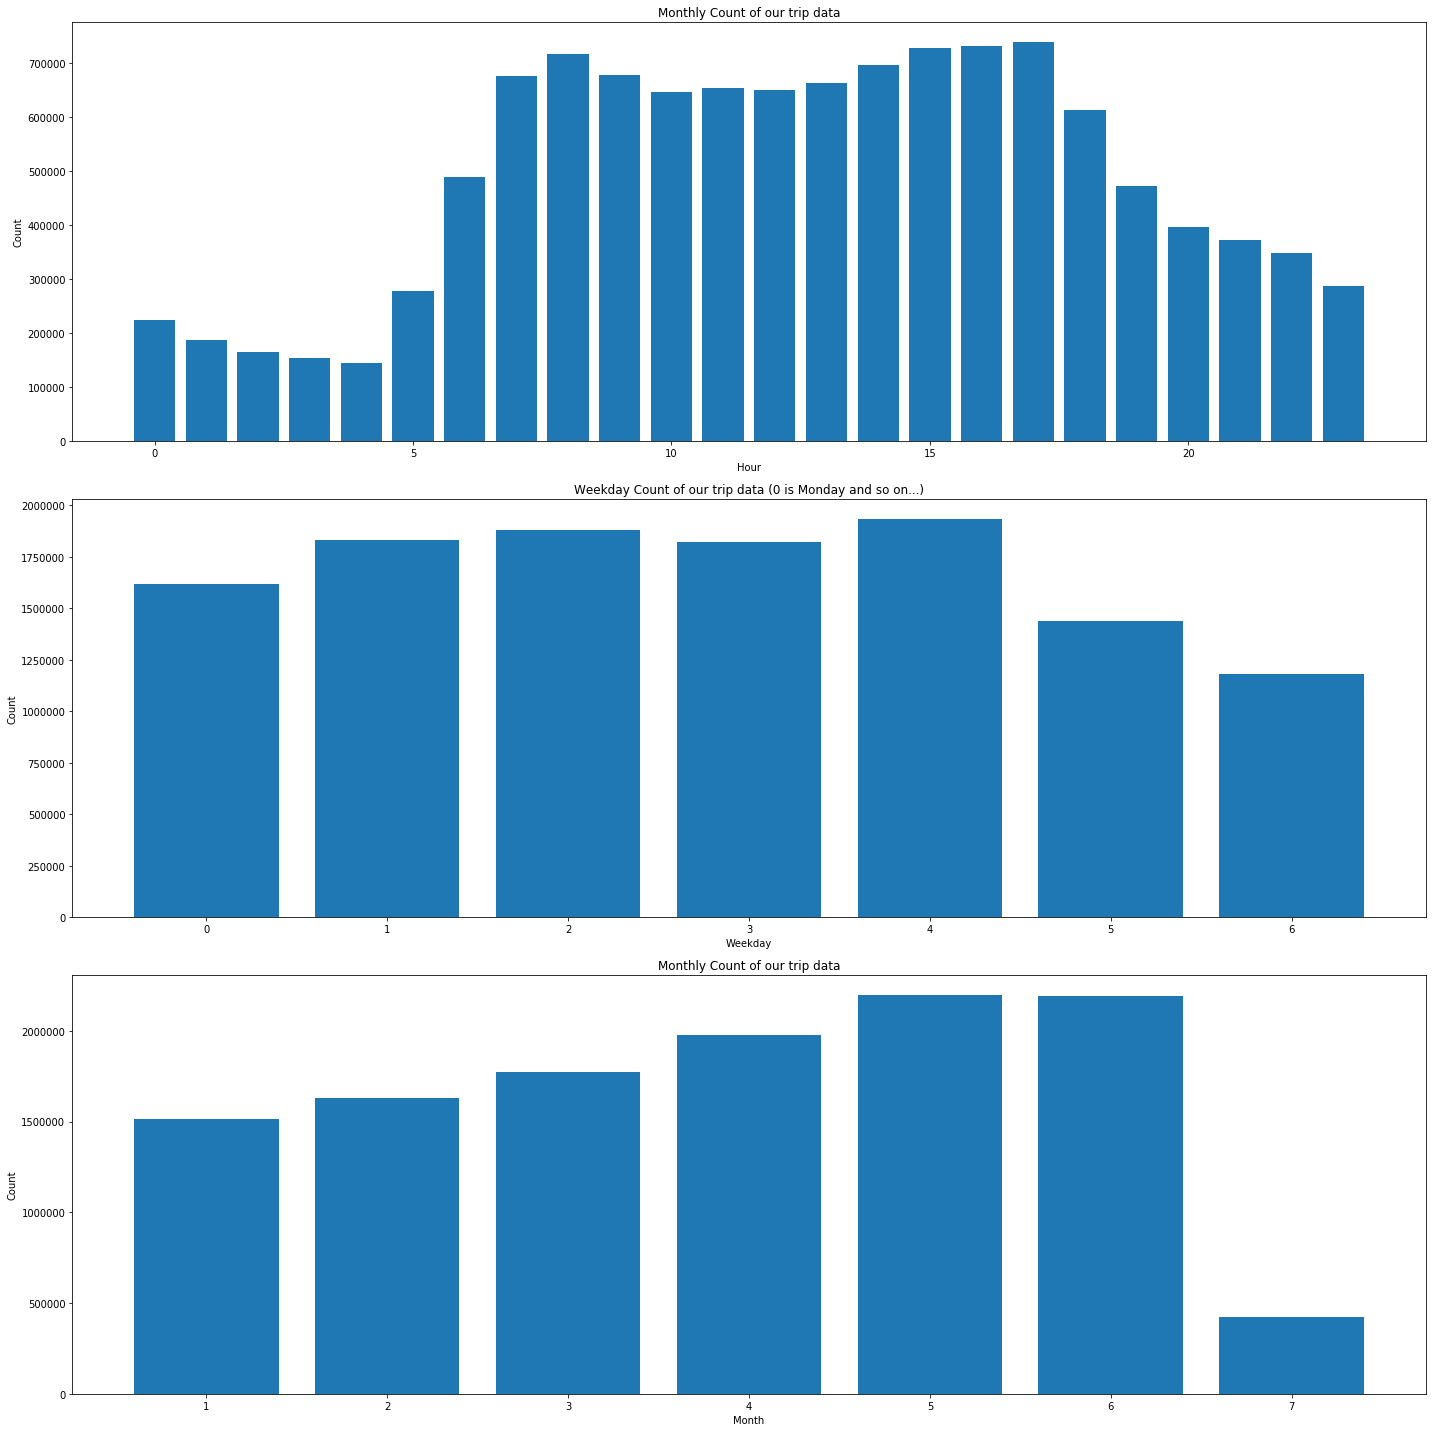

In [69]:
plt.subplots(1,3, figsize=(20, 20)) 

plt.subplot(3,1,1) 
plt.bar(hourly_count.index,hourly_count)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Monthly Count of our trip data')

plt.subplot(3,1,2) 
plt.bar(weekday_count.index,weekday_count)
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Weekday Count of our trip data (0 is Monday and so on...)')

plt.subplot(3,1,3) 
plt.bar(month_count.index,month_count)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Count of our trip data')


plt.tight_layout()

plt.show()

The month of July does not have a lot of trips recorded but later in our analysis we will convert months into seasons so we do not have to factor in the disporportionate number of trips in July.

### Join the cleaned individual dataframes to create a master dataframe with all the features


Stage 1 on joining will be to zip month and day columns in trips and weather to use it as index for join. 

In [70]:
#Creating columns to join the daily weather and trips datasets
weather_d['Day_Month'] = list(zip(weather_d.Day, weather_d.Month))
trips['Day_Month'] = list(zip(trips.day_of_month, trips.month))

In [71]:
#Creating columns to join the hourly weather and trips datasets using the format (dd, mm, hh)
trips['Day_Month_Hour'] = list(zip(trips.day_of_month, trips.month, trips.hour))
weather_h ['Day_Month_Hour'] = list(zip(weather_h.Day, weather_h.Month, weather_h.hour))

In [72]:
weather_h.head()

,Date/Time,Month,Day,Time,Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Weather,hour,Day_Month_Hour
0,2019-01-01 00:00,1,1,00:00,1.9,94.0,12.0,26.0,8.1,5,0,"(1, 1, 0)"
1,2019-01-01 01:00,1,1,01:00,1.7,92.0,14.0,28.0,4.8,5,1,"(1, 1, 1)"
2,2019-01-01 02:00,1,1,02:00,1.9,94.0,12.0,17.0,4.8,5,2,"(1, 1, 2)"
3,2019-01-01 03:00,1,1,03:00,2.3,94.0,10.0,22.0,9.7,5,3,"(1, 1, 3)"
4,2019-01-01 04:00,1,1,04:00,2.0,95.0,2.0,18.0,8.1,5,4,"(1, 1, 4)"


In [73]:
#Lets drop excessive columns we dont need or will be a duplicate before joining
weather_h.drop(['Date/Time', 'Month', 'Day', 'Time', 'hour'], axis=1, inplace = True)

In [74]:
#Joining daily weather and trips data first
#using left join to keep the weather data only for the days we have the information for in our trips dataset
master_df = trips.join(weather_d.set_index('Day_Month'), on='Day_Month', how = 'left')

In [75]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,trip_start,trip_end,month,weekday,hour,day_of_month,Day_Month,Day_Month_Hour,Date/Time,Month,Day,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,LSD_89-87,89,87,308,13.044706,85,2019-01-01 04:42:17,2019-01-01 04:43:42,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
1,LRL_37-1B,37,1B,435,11.863636,132,2019-01-01 04:41:31,2019-01-01 04:43:43,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
2,LSD_50-30,50,30,476,24.135211,71,2019-01-01 04:42:33,2019-01-01 04:43:44,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
4,LND_1B-98,1B,98,369,53.136000,25,2019-01-01 04:43:21,2019-01-01 04:43:46,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
5,LSD_89-87,89,87,308,20.160000,55,2019-01-01 04:42:51,2019-01-01 04:43:46,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0


In [76]:
#lets see what columns do we have in our partial data set and get rid of any duplicate columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11704293 entries, 0 to 14800950
Data columns (total 20 columns):
 #   Column             Dtype         
---  ------             -----         
 0   LinkId             object        
 1   SrcDetectorId      object        
 2   DestDetectorId     object        
 3   PathDistance_m     int64         
 4   Speed_kmh          float64       
 5   TravelTime_s       int64         
 6   trip_start         datetime64[ns]
 7   trip_end           datetime64[ns]
 8   month              int64         
 9   weekday            int64         
 10  hour               int64         
 11  day_of_month       int64         
 12  Day_Month          object        
 13  Day_Month_Hour     object        
 14  Date/Time          object        
 15  Month              int64         
 16  Day                int64         
 17  Total Rain (mm)    float64       
 18  Total Snow (cm)    float64       
 19  Snow on Grnd (cm)  float64       
dtypes: datetime64[ns](2), 

I see a lot of date and time columns repeated so we will remove them from the `master_df` before moving forward.

In [77]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,trip_start,trip_end,month,weekday,hour,day_of_month,Day_Month,Day_Month_Hour,Date/Time,Month,Day,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,LSD_89-87,89,87,308,13.044706,85,2019-01-01 04:42:17,2019-01-01 04:43:42,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
1,LRL_37-1B,37,1B,435,11.863636,132,2019-01-01 04:41:31,2019-01-01 04:43:43,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
2,LSD_50-30,50,30,476,24.135211,71,2019-01-01 04:42:33,2019-01-01 04:43:44,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
4,LND_1B-98,1B,98,369,53.136000,25,2019-01-01 04:43:21,2019-01-01 04:43:46,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0
5,LSD_89-87,89,87,308,20.160000,55,2019-01-01 04:42:51,2019-01-01 04:43:46,1,1,4,1,"(1, 1)","(1, 1, 4)",2019-01-01,1,1,16.8,0.2,0.0


In [78]:
#Now lets join the hourly weather data with master_df
#using left join to keep the hourly weather data only for the time we have the information for in our trips dataset
master_df = master_df.join(weather_h.set_index('Day_Month_Hour'), on='Day_Month_Hour', how = 'left')

In [79]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,trip_start,trip_end,month,weekday,...,Day,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm),Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Weather
0,LSD_89-87,89,87,308,13.044706,85,2019-01-01 04:42:17,2019-01-01 04:43:42,1,1,...,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
1,LRL_37-1B,37,1B,435,11.863636,132,2019-01-01 04:41:31,2019-01-01 04:43:43,1,1,...,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
2,LSD_50-30,50,30,476,24.135211,71,2019-01-01 04:42:33,2019-01-01 04:43:44,1,1,...,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
4,LND_1B-98,1B,98,369,53.136000,25,2019-01-01 04:43:21,2019-01-01 04:43:46,1,1,...,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
5,LSD_89-87,89,87,308,20.160000,55,2019-01-01 04:42:51,2019-01-01 04:43:46,1,1,...,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5


In [80]:
#Since we have already splitted month/ day/ hour/weekday into different columns,
#we will also drop `trip_start` and 'trip_end'
master_df.drop(['Day_Month', 'Date/Time', 'Month', 'Day', 'trip_end', 'trip_start', 'Day_Month_Hour'], axis=1, inplace = True)

In [81]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,month,weekday,hour,day_of_month,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm),Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Weather
0,LSD_89-87,89,87,308,13.044706,85,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
1,LRL_37-1B,37,1B,435,11.863636,132,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
2,LSD_50-30,50,30,476,24.135211,71,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
4,LND_1B-98,1B,98,369,53.136000,25,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5
5,LSD_89-87,89,87,308,20.160000,55,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5


For stage 2 we will analyse the `segments` dataframe to see if there is any column that can add the predicive power to our model. 

In [82]:
segments.head()

,channel_name,LinkID,SrcDetectorId,SrcLatitude,SrcLongitude,DestDetectorId,DestLatitude,DestLongitude,LinkName,RouteDirectionName,LineDistance_m
0,Saint-Michel-Industriel,LCh_10-16,10,45.5760283333333,-73.6364616666667,16,45.564785,-73.6449433333333,Charland:Saint-Michel a Papineau,W,1410
1,Papineau-charland,LCh_16-10,16,45.564785,-73.6449433333333,10,45.5760283333333,-73.6364616666667,Charland:Papineau a Saint-Michel,N,1414
2,Papineau-Henri-Bourassa,LHB_15-20,15,45.5702683333333,-73.6588066666667,20,45.555365,-73.6683933333333,Henri-Bourassa:Papineau a Lajeunesse,W,1818
3,Henri-Bourassa-Lajeunesse,LHB_20-15,20,45.555365,-73.6683933333333,15,45.5702683333333,-73.6588066666667,Henri-Bourassa:Lajeunesse a Papineau,N,1818
4,Henri-Bourassa-Lajeunesse,LHB_20-21,20,45.555365,-73.6683933333333,21,45.5349866666667,-73.6807116666667,Henri_Bourassa:Lajeunesse a Bourassa-Acadie,W,2460


After analyzing these columns we conclude that most of the columns in `segments` dataframe are nominal and they would not add any additional predictive power to our model except for maybe the direction of the route which we should add to `master_df`. For this purpose we will create a temporary_df from a copy of segments and keep only `RouteDirectionName` and `LinkID` and then join it with the `master_df`.

In [83]:
temp_df = segments[['LinkID', 'RouteDirectionName']]

In [84]:
#Joining directions from the segments data and trips data with inner join 
#This way we will ensure that the segments which have direction associated with us are only ones left for our modelling.
master_df = master_df.join(temp_df.set_index('LinkID'), on='LinkId', how = 'inner')

In [85]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,month,weekday,hour,day_of_month,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm),Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Weather,RouteDirectionName
0,LSD_89-87,89,87,308,13.044706,85,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
5,LSD_89-87,89,87,308,20.160000,55,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
35,LSD_89-87,89,87,308,34.650000,32,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
159,LSD_89-87,89,87,308,15.616901,71,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
263,LSD_89-87,89,87,308,32.611765,34,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S


In [86]:
master_df.reset_index(inplace = True)
master_df.drop(['index'], axis=1, inplace = True)

In [87]:
master_df.head()

,LinkId,SrcDetectorId,DestDetectorId,PathDistance_m,Speed_kmh,TravelTime_s,month,weekday,hour,day_of_month,Total Rain (mm),Total Snow (cm),Snow on Grnd (cm),Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Weather,RouteDirectionName
0,LSD_89-87,89,87,308,13.044706,85,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
1,LSD_89-87,89,87,308,20.160000,55,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
2,LSD_89-87,89,87,308,34.650000,32,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
3,LSD_89-87,89,87,308,15.616901,71,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
4,LSD_89-87,89,87,308,32.611765,34,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S


In [88]:
master_df.isna().sum()

#clean data ready for processing 

LinkId                0
SrcDetectorId         0
DestDetectorId        0
PathDistance_m        0
Speed_kmh             0
TravelTime_s          0
month                 0
weekday               0
hour                  0
day_of_month          0
Total Rain (mm)       0
Total Snow (cm)       0
Snow on Grnd (cm)     0
Temp (°C)             0
Rel Hum (%)           0
Wind Dir (10s deg)    0
Wind Spd (km/h)       0
Visibility (km)       0
Weather               0
RouteDirectionName    0
dtype: int64

It looks like our data is all clean and we have all needed features to go ahead with feature engineering and some more EDA later on. So now we will first rename the columns to make them more readable and easier to use for our work. 

In [89]:
#renaming the columns to match formatting of all lowercase
master_df.rename(columns={"LinkId": "link_id", "SrcDetectorId": "source_id", "DestDetectorId": "destination_id",
            "PathDistance_m": "distance_m","Speed_kmh": "speed_kmh","TravelTime_s": "travel_time_sec",
            "RouteDirectionName": "direction", "Temp (°C)": "mean_temp_celcius", "Total Rain (mm)": "rain_mm",
            "Total Snow (cm)": "snow_cm", "Snow on Grnd (cm)": "snow_on_ground_cm", 
            "Wind Spd (km/h)": "wind_speed_kmh", "Wind Dir (10s deg)": "wind_direction",
            "Rel Hum (%)": "humidity_percentage", "Visibility (km)": "visibility_km", "Weather": "weather_conditions"},
                 inplace = True)

In [90]:
master_df.head()

,link_id,source_id,destination_id,distance_m,speed_kmh,travel_time_sec,month,weekday,hour,day_of_month,rain_mm,snow_cm,snow_on_ground_cm,mean_temp_celcius,humidity_percentage,wind_direction,wind_speed_kmh,visibility_km,weather_conditions,direction
0,LSD_89-87,89,87,308,13.044706,85,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
1,LSD_89-87,89,87,308,20.160000,55,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
2,LSD_89-87,89,87,308,34.650000,32,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
3,LSD_89-87,89,87,308,15.616901,71,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S
4,LSD_89-87,89,87,308,32.611765,34,1,1,4,1,16.8,0.2,0.0,2.0,95.0,2.0,18.0,8.1,5,S


In [91]:
master_df.shape

(11151705, 20)

In [92]:
master_df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_m,11151705.0,869.183438,660.385999,101.0,369.000000,600.00000,1229.000000,4213.000000
speed_kmh,11151705.0,29.376720,13.473607,10.0,18.712088,26.55894,37.894737,64.989474
travel_time_sec,11151705.0,126.582653,112.536976,7.0,46.000000,90.00000,173.000000,960.000000
month,11151705.0,3.865067,1.761144,1.0,2.000000,4.00000,5.000000,7.000000
weekday,11151705.0,2.828661,1.887820,0.0,1.000000,3.00000,4.000000,6.000000
hour,11151705.0,12.590827,5.644988,0.0,8.000000,13.00000,17.000000,23.000000
day_of_month,11151705.0,15.466078,8.868266,1.0,8.000000,16.00000,23.000000,31.000000
rain_mm,11151705.0,2.325211,5.277094,0.0,0.000000,0.00000,1.600000,31.000000
snow_cm,11151705.0,0.702051,2.704723,0.0,0.000000,0.00000,0.000000,20.600000
snow_on_ground_cm,11151705.0,5.272406,8.901139,0.0,0.000000,0.00000,6.000000,30.000000


In [93]:
corr_df= master_df.corr()
corr_df

,distance_m,speed_kmh,travel_time_sec,month,weekday,hour,day_of_month,rain_mm,snow_cm,snow_on_ground_cm,mean_temp_celcius,humidity_percentage,wind_direction,wind_speed_kmh,visibility_km
distance_m,1.000000,0.010229,0.823759,-0.010954,-0.002544,-0.002829,-0.006511,-0.003290,0.002203,0.008573,-0.013567,-0.002685,-0.003450,0.010159,0.006027
speed_kmh,0.010229,1.000000,-0.388796,-0.007707,0.031301,-0.028455,-0.006885,-0.003316,-0.017280,-0.003019,-0.024729,0.028696,0.004324,-0.032100,-0.031687
travel_time_sec,0.823759,-0.388796,1.000000,-0.003062,-0.025067,0.014218,0.000428,-0.000454,0.013311,0.008001,0.005570,-0.021087,-0.005985,0.030405,0.027278
month,-0.010954,-0.007707,-0.003062,1.000000,0.028785,0.004965,-0.113695,0.127410,-0.281667,-0.588865,0.895690,-0.197171,-0.012580,-0.148328,0.329259
weekday,-0.002544,0.031301,-0.025067,0.028785,1.000000,0.019728,0.016406,0.087837,-0.043390,-0.031891,0.077321,0.113132,-0.013895,-0.062569,-0.074499
hour,-0.002829,-0.028455,0.014218,0.004965,0.019728,1.000000,0.001815,-0.000638,-0.005090,-0.001100,0.105560,-0.206263,0.065018,0.078155,0.003311
day_of_month,-0.006511,-0.006885,0.000428,-0.113695,0.016406,0.001815,1.000000,0.104786,-0.028405,-0.009248,0.006354,0.021197,0.037787,-0.011321,0.046925
rain_mm,-0.003290,-0.003316,-0.000454,0.127410,0.087837,-0.000638,0.104786,1.000000,-0.053806,-0.166748,0.165310,0.330106,-0.211644,0.079273,-0.205348
snow_cm,0.002203,-0.017280,0.013311,-0.281667,-0.043390,-0.005090,-0.028405,-0.053806,1.000000,0.212557,-0.264130,0.194918,-0.186102,0.073728,-0.276822
snow_on_ground_cm,0.008573,-0.003019,0.008001,-0.588865,-0.031891,-0.001100,-0.009248,-0.166748,0.212557,1.000000,-0.607751,0.131729,0.058314,0.087968,-0.226018


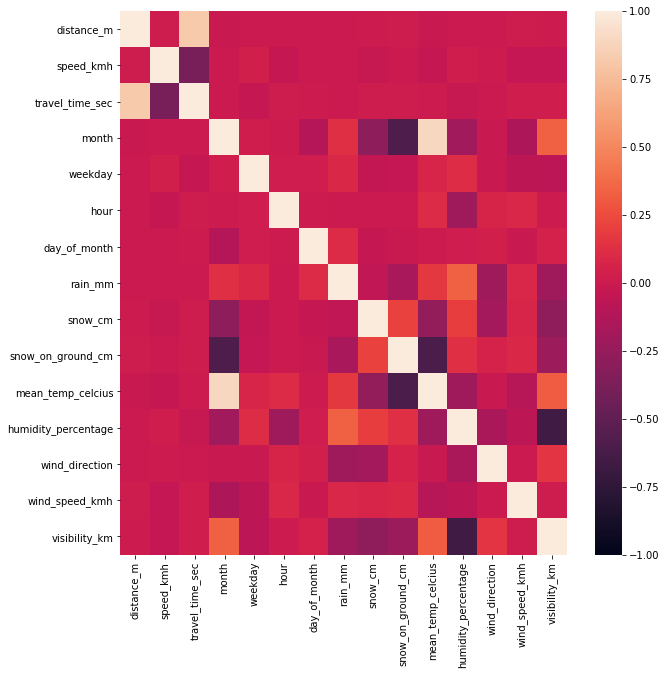

In [94]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(corr_df,vmin=-1, vmax=1)
sns.heatmap;

The data looks good as there is very little colinearity between the selected features. There is relatively stronger relationship between `travel_time_sec` and `speed_kmh` but since our target variable is `travel_time_sec` we can ignore this. On the other hand `month` and weather features such as `snow_on_ground_cm` and `mean_temp_celcius` are directly correlated and we will address this after feature engineering and extracting useful information out of month such as season. Rest of the features look decently independent of each other. 

## Basic Feature Engineering (Encoding data)

In [97]:
#Changing weekday column into binary classification where Mon - Fri will be treated as weekdays i.e. 1 and rest will be 0.

master_df['weekday'] = (master_df['weekday'] < 5).astype(int)
master_df['weekday'].value_counts()

1    8649096
0    2502609
Name: weekday, dtype: int64

In [98]:
# We will use mapping function to convert directions column into numeric degree values to match with gust direction values
# i.e. East = 90 and North 360 and so on

mapping = {'E':90, 'S':180, 'W':270, 'N':360}
master_df['route_direction'] = master_df['direction'].map(mapping)

In [99]:
#Making a new column for winter and other weather for road conditions. Jan, Feb, March and April  will be considered as winter
master_df['winter'] = (master_df['month'] < 5).astype(int)
master_df['winter'].value_counts()

1    6545716
0    4605989
Name: winter, dtype: int64

In [100]:
#Since Rush hour plays an important role in traffic flow we will be
#Defining rush hour to be between 7 am to 10 am and 3pm to 6pm Monday to Friday only. 
master_df['rush_hour'] = ((((master_df['hour'] >= 7 ) & (master_df['hour'] <= 10)) | ((master_df['hour'] >= 15) & (master_df['hour'] <= 18))) 
                     &(master_df['weekday'] < 5)).astype(int)

master_df['rush_hour'].value_counts()

0    5944139
1    5207566
Name: rush_hour, dtype: int64

Now we should drop any extra columns that we used to create new columns and provide no additional information other than the one captured by the new feature. Therefore we will drop `direction`, `day_of_month` and `month` columns. 

In [101]:
master_df.drop(['direction', 'day_of_month', 'month'], axis=1, inplace = True) 

In [102]:
master_df.shape

(11151705, 20)

Now lets rearrange our column names to make our target variable `travel_time_sec` as the last column and put other columns in the order of nominal, ordinal and then parametric variables.

In [103]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11151705 entries, 0 to 11151704
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   link_id              object 
 1   source_id            object 
 2   destination_id       object 
 3   distance_m           int64  
 4   speed_kmh            float64
 5   travel_time_sec      int64  
 6   weekday              int32  
 7   hour                 int64  
 8   rain_mm              float64
 9   snow_cm              float64
 10  snow_on_ground_cm    float64
 11  mean_temp_celcius    float64
 12  humidity_percentage  float64
 13  wind_direction       float64
 14  wind_speed_kmh       float64
 15  visibility_km        float64
 16  weather_conditions   object 
 17  route_direction      int64  
 18  winter               int32  
 19  rush_hour            int32  
dtypes: float64(9), int32(3), int64(4), object(4)
memory usage: 1.5+ GB


In [105]:
#Rearranging columns

master_df = master_df[['link_id', 'source_id', 'destination_id', 'route_direction','weekday', 'hour', 'rush_hour','winter',
                       'visibility_km', 'humidity_percentage', 'mean_temp_celcius', 'rain_mm', 'snow_cm',
                       'snow_on_ground_cm', 'wind_speed_kmh', 'wind_direction', 'weather_conditions', 'distance_m',
                       'speed_kmh' ,'travel_time_sec']]

In [106]:
#Changing column data type for weather_conditions
master_df['weather_conditions'] = master_df['weather_conditions'].astype('int')

In [107]:
master_df.shape


(11151705, 20)

In [108]:
#lets recheck the correlation between our final dataset and the target variable i.e `travel_time_sec`

master_df.corr().tail(1).T

,travel_time_sec
route_direction,0.174119
weekday,0.034248
hour,0.014218
rush_hour,0.077948
winter,0.002994
visibility_km,0.027278
humidity_percentage,-0.021087
mean_temp_celcius,0.005570
rain_mm,-0.000454
snow_cm,0.013311


## Graphing attmept to ensure our data is part of all big one network


In [109]:
#Creating a tuple of lists for our edges
source = master_df['source_id'].astype('str')
destination = master_df ['destination_id'].astype('str')
edges =  list(zip(source, destination))

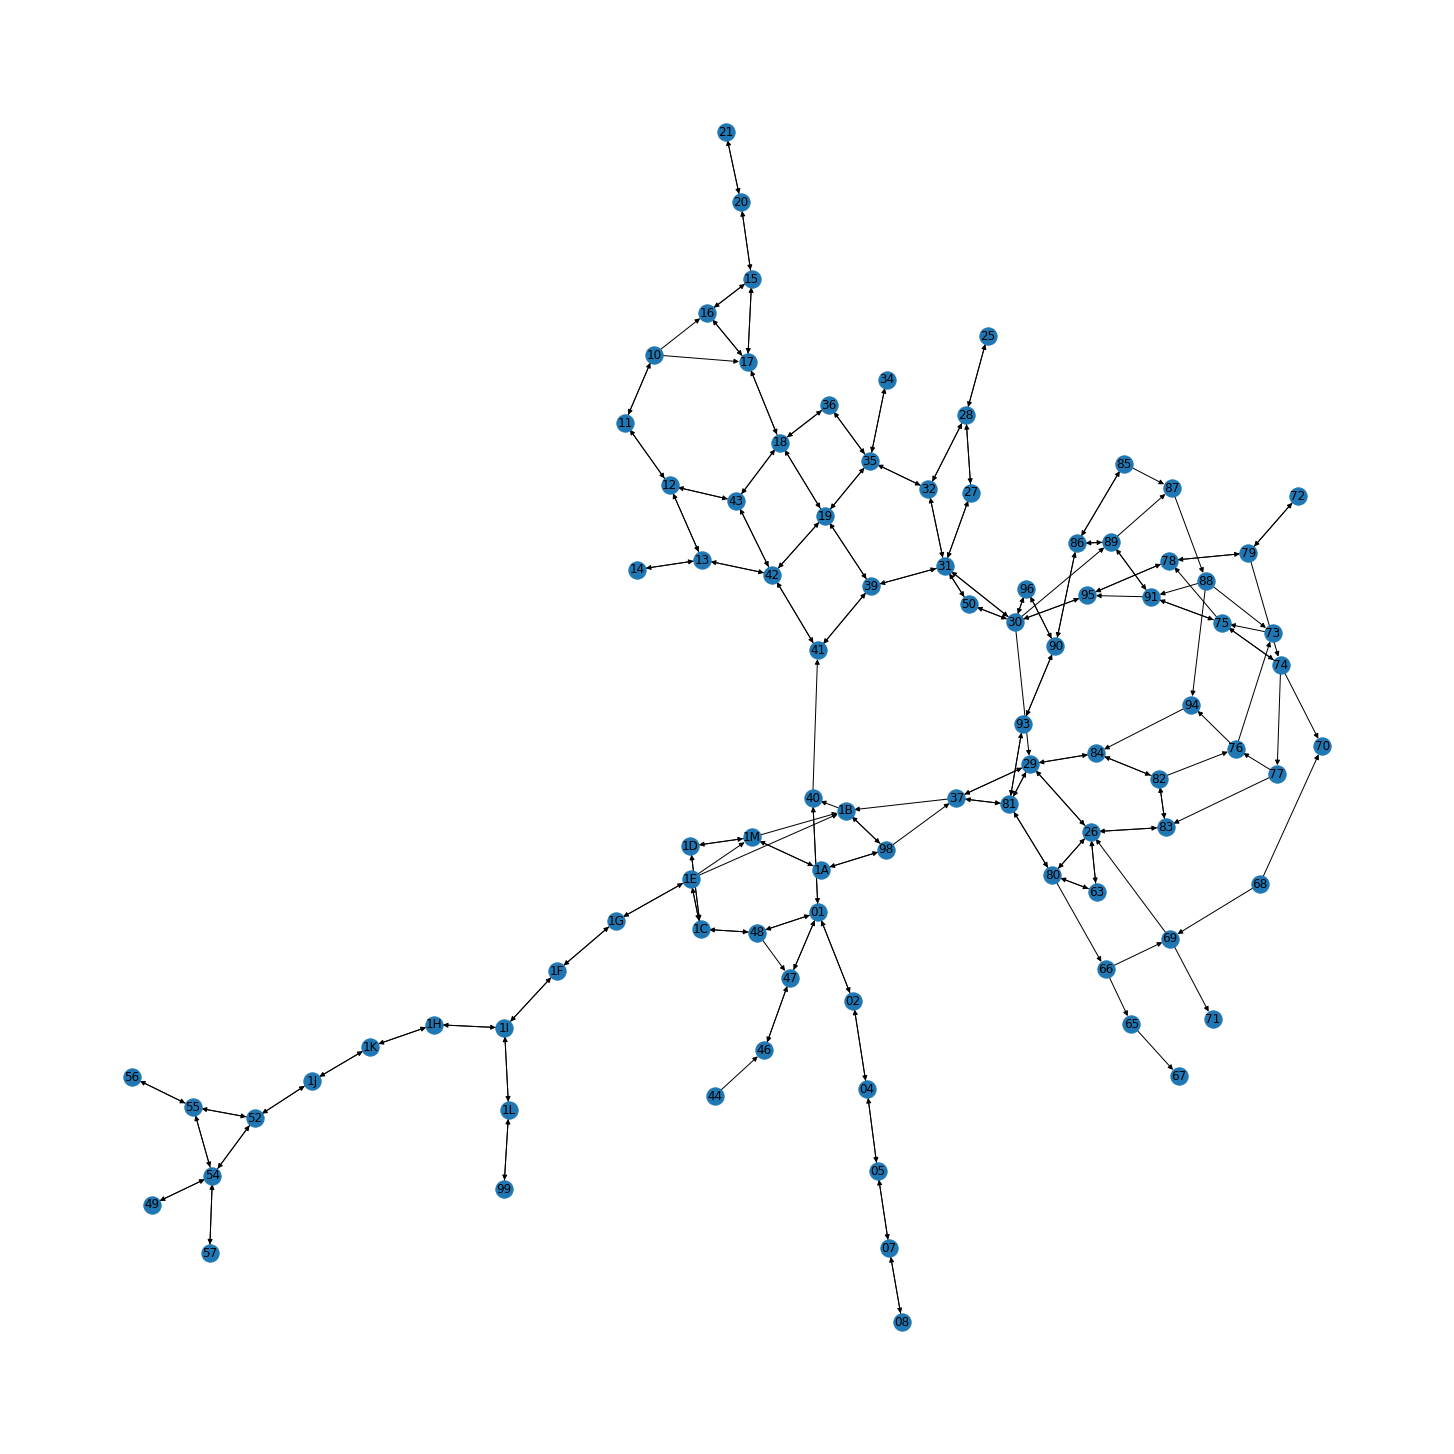

In [110]:
#Creating a network with the edges
road_map=nx.DiGraph()
road_map.add_edges_from(edges)

plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(road_map, with_labels = True)

## Exporting the Pre- Processed data

## **** READ BELOW *****

In [111]:
#Uncomment the code below to generate a file to be ready and feed into capstone_modelling_v2.ipynb

#master_df.to_csv('pre_processed_data.csv')

## THE END!

##### Proceed to modeling file.
